In [8]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import hilbert, butter, filtfilt
import matplotlib.pyplot as plt
from scipy import stats
import librosa

=== Evaluation Results for Signal 1 ===
SNR (dB): 17.4842
MSE: 196213.1875
PSNR (dB): 37.3815
Cross-correlation: 0.9914
Spectral Distortion: 0.0000
PESQ (approx.): 3.9772

=== Evaluation Results for Signal 2 ===
SNR (dB): 16.0871
MSE: 112629.0781
PSNR (dB): 39.7922
Cross-correlation: 0.9876
Spectral Distortion: 0.0000
PESQ (approx.): 4.1082


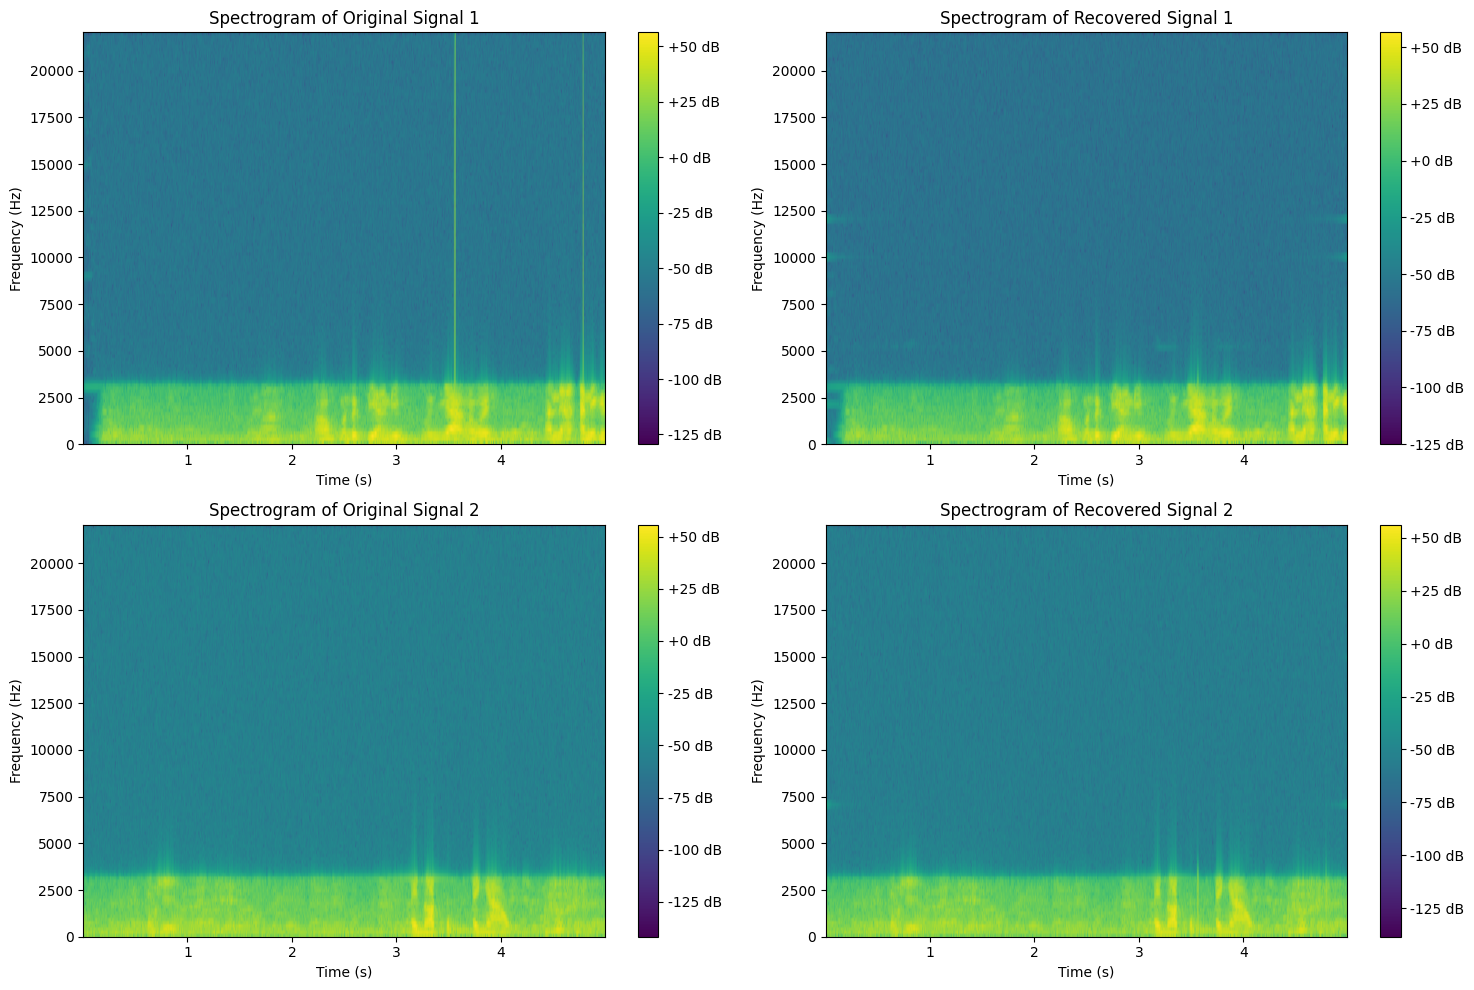

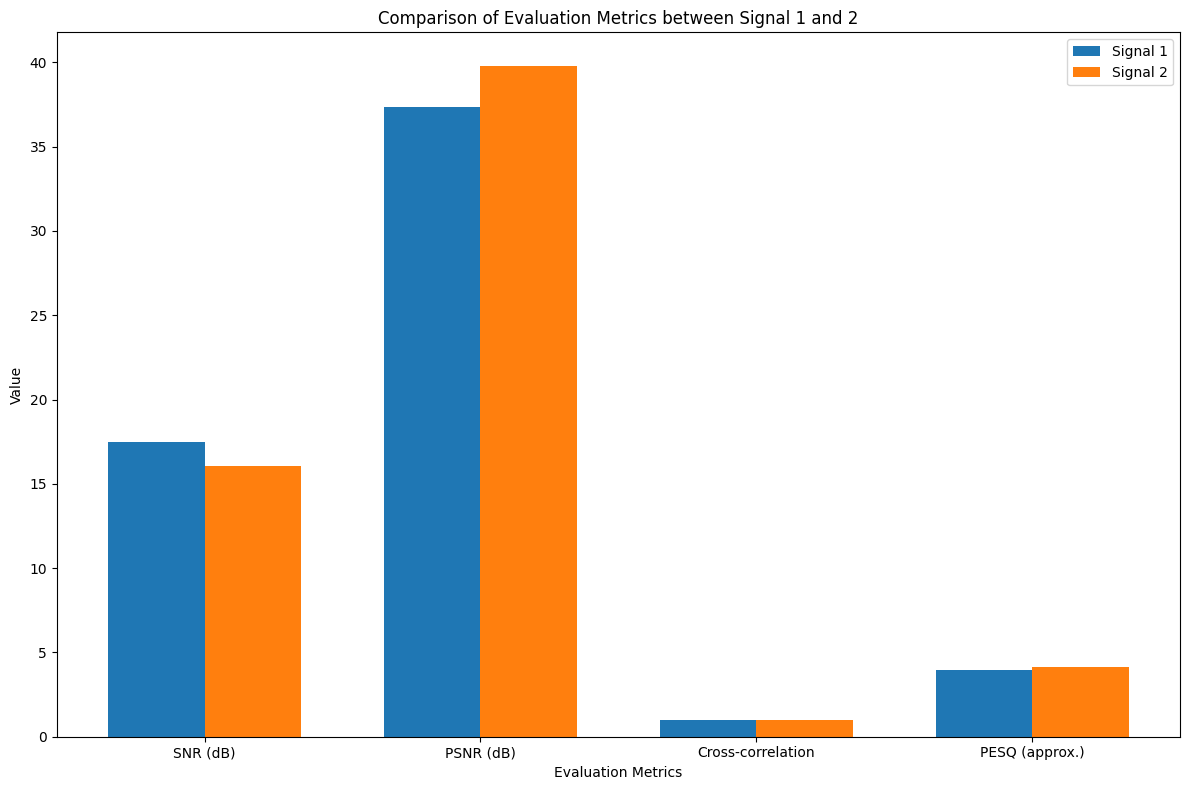

In [1]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import hilbert, butter, filtfilt
import matplotlib.pyplot as plt
from scipy import stats
import librosa

def snr(original, processed):
    """
    Calculate Signal-to-Noise Ratio (SNR)
    SNR = 10 * log10(P_signal / P_noise)
    where P_signal is the power of the original signal and P_noise is the power of the noise
    """
    # Adjust to equal size
    min_len = min(len(original), len(processed))
    original = original[:min_len]
    processed = processed[:min_len]
    
    # Calculate noise signal
    noise = original - processed
    
    # Calculate signal power
    signal_power = np.sum(original**2) / len(original)
    noise_power = np.sum(noise**2) / len(noise)
    
    if noise_power == 0:  # Prevent division by zero
        return float('inf')
    
    # Calculate SNR in dB
    snr_db = 10 * np.log10(signal_power / noise_power)
    return snr_db

def mse(original, processed):
    """
    Calculate Mean Squared Error (MSE)
    MSE = (1/n) * Σ(original_i - processed_i)²
    """
    # Adjust to equal size
    min_len = min(len(original), len(processed))
    original = original[:min_len]
    processed = processed[:min_len]
    
    # Calculate MSE
    mse_value = np.mean((original - processed)**2)
    return mse_value

def psnr(original, processed):
    """
    Calculate Peak Signal-to-Noise Ratio (PSNR)
    PSNR = 10 * log10(MAX² / MSE)
    where MAX is the maximum possible value of the signal (e.g., 32767 for 16-bit audio)
    """
    # Calculate MSE value
    mse_value = mse(original, processed)
    
    if mse_value == 0:  # Prevent division by zero
        return float('inf')
    
    # For 16-bit audio, MAX = 32767
    max_value = 32767
    
    # Calculate PSNR in dB
    psnr_db = 10 * np.log10((max_value**2) / mse_value)
    return psnr_db

def cross_correlation(original, processed):
    """
    Calculate Cross-correlation between the original signal and processed signal
    Value ranges from -1 to 1, where 1 means signals are perfectly identical
    """
    # Adjust to equal size
    min_len = min(len(original), len(processed))
    original = original[:min_len]
    processed = processed[:min_len]
    
    # Calculate correlation
    correlation = np.corrcoef(original, processed)[0, 1]
    return correlation

def spectral_distortion(original, processed, fs):
    """
    Calculate Spectral Distortion by measuring the distance 
    between spectra of the original signal and the processed signal
    """
    # Adjust to equal size
    min_len = min(len(original), len(processed))
    original = original[:min_len]
    processed = processed[:min_len]
    
    # Calculate spectrum (magnitude)
    freq_orig, spec_orig = np.fft.rfftfreq(len(original), 1/fs), np.abs(np.fft.rfft(original))
    freq_proc, spec_proc = np.fft.rfftfreq(len(processed), 1/fs), np.abs(np.fft.rfft(processed))
    
    # Normalize spectra
    spec_orig = spec_orig / np.max(spec_orig)
    spec_proc = spec_proc / np.max(spec_proc)
    
    # Calculate Euclidean distance
    distance = np.sqrt(np.sum((spec_orig - spec_proc)**2)) / len(spec_orig)
    return distance

def pesq_approximation(original, processed, fs):
    """
    Calculate an approximation of PESQ (Perceptual Evaluation of Speech Quality)
    by measuring the similarity of MFCC (Mel-Frequency Cepstral Coefficients) features
    
    Note: This is a simple approximation, not the actual PESQ calculation
    which requires specialized libraries like pypesq
    """
    # Adjust to equal size
    min_len = min(len(original), len(processed))
    original = original[:min_len]
    processed = processed[:min_len]
    
    # Calculate MFCC
    mfcc_orig = librosa.feature.mfcc(y=original.astype(float), sr=fs, n_mfcc=13)
    mfcc_proc = librosa.feature.mfcc(y=processed.astype(float), sr=fs, n_mfcc=13)
    
    # Calculate distance between MFCC features
    mfcc_distance = np.mean(np.sqrt(np.sum((mfcc_orig - mfcc_proc)**2, axis=0)))
    
    # Convert to a PESQ-like range (1.0 - 4.5)
    # Lower distance means better quality
    pesq_approx = 4.5 - 3.5 * (mfcc_distance / 100)
    pesq_approx = max(1.0, min(4.5, pesq_approx))  # Constrain range to 1.0 - 4.5
    
    return pesq_approx

def evaluate_system(original_file1, original_file2, recovered_file1, recovered_file2):
    """
    Evaluate system performance by comparing original files with recovered files
    """
    # Read files
    fs1, original1 = wavfile.read(original_file1)
    fs2, original2 = wavfile.read(original_file2)
    fs3, recovered1 = wavfile.read(recovered_file1)
    fs4, recovered2 = wavfile.read(recovered_file2)
    
    # Convert to float for calculations
    original1 = original1.astype(np.float32)
    original2 = original2.astype(np.float32)
    recovered1 = recovered1.astype(np.float32)
    recovered2 = recovered2.astype(np.float32)
    
    # Check if sampling rates match
    if fs1 != fs3 or fs2 != fs4:
        print("Warning: Sampling rates of original and recovered files don't match")
    
    # Calculate various metrics
    metrics1 = {
        "SNR (dB)": snr(original1, recovered1),
        "MSE": mse(original1, recovered1),
        "PSNR (dB)": psnr(original1, recovered1),
        "Cross-correlation": cross_correlation(original1, recovered1),
        "Spectral Distortion": spectral_distortion(original1, recovered1, fs1),
        "PESQ (approx.)": pesq_approximation(original1, recovered1, fs1)
    }
    
    metrics2 = {
        "SNR (dB)": snr(original2, recovered2),
        "MSE": mse(original2, recovered2),
        "PSNR (dB)": psnr(original2, recovered2),
        "Cross-correlation": cross_correlation(original2, recovered2),
        "Spectral Distortion": spectral_distortion(original2, recovered2, fs2),
        "PESQ (approx.)": pesq_approximation(original2, recovered2, fs2)
    }
    
    # Summary of evaluation results
    print("=== Evaluation Results for Signal 1 ===")
    for metric, value in metrics1.items():
        print(f"{metric}: {value:.4f}")
    
    print("\n=== Evaluation Results for Signal 2 ===")
    for metric, value in metrics2.items():
        print(f"{metric}: {value:.4f}")
    
    # Create comparison graphs
    plt.figure(figsize=(15, 10))
    
    # Spectrogram graphs for Signal 1 (original vs recovered)
    plt.subplot(2, 2, 1)
    plt.specgram(original1, Fs=fs1, cmap='viridis')
    plt.title('Spectrogram of Original Signal 1')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(format='%+2.0f dB')
    
    plt.subplot(2, 2, 2)
    plt.specgram(recovered1, Fs=fs3, cmap='viridis')
    plt.title('Spectrogram of Recovered Signal 1')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(format='%+2.0f dB')
    
    # Spectrogram graphs for Signal 2 (original vs recovered)
    plt.subplot(2, 2, 3)
    plt.specgram(original2, Fs=fs2, cmap='viridis')
    plt.title('Spectrogram of Original Signal 2')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(format='%+2.0f dB')
    
    plt.subplot(2, 2, 4)
    plt.specgram(recovered2, Fs=fs4, cmap='viridis')
    plt.title('Spectrogram of Recovered Signal 2')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    plt.savefig('spectrograms_comparison.png')
    
    # Create bar graph comparing metrics
    plt.figure(figsize=(12, 8))
    
    metrics_to_plot = ["SNR (dB)", "PSNR (dB)", "Cross-correlation", "PESQ (approx.)"]
    x = np.arange(len(metrics_to_plot))
    width = 0.35
    
    values1 = [metrics1[m] for m in metrics_to_plot]
    values2 = [metrics2[m] for m in metrics_to_plot]
    
    plt.bar(x - width/2, values1, width, label='Signal 1')
    plt.bar(x + width/2, values2, width, label='Signal 2')
    
    plt.xlabel('Evaluation Metrics')
    plt.ylabel('Value')
    plt.title('Comparison of Evaluation Metrics between Signal 1 and 2')
    plt.xticks(x, metrics_to_plot)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('metrics_comparison.png')
    
    return metrics1, metrics2

# Example usage
if __name__ == "__main__":
    # Specify paths to original and recovered files
    original_file1 = './soundwav/output_deletenoise1.wav'
    original_file2 = './soundwav/output_deletenoise2.wav'
    recovered_file1 = './soundwav/extracted_audio1.wav'
    recovered_file2 = './soundwav/extracted_audio2.wav'
    
    # Evaluate system performance
    metrics1, metrics2 = evaluate_system(original_file1, original_file2, recovered_file1, recovered_file2)

In [ ]:
def snr(original, processed):
    """
    Calculate Signal-to-Noise Ratio (SNR)
    SNR = 10 * log10(P_signal / P_noise)
    where P_signal is the power of the original signal and P_noise is the power of the noise
    """
    # Ensure equal length
    min_len = min(len(original), len(processed))
    original = original[:min_len]
    processed = processed[:min_len]
    
    # Calculate noise signal
    noise = original - processed
    
    # Calculate signal and noise power
    signal_power = np.sum(original**2) / len(original)
    noise_power = np.sum(noise**2) / len(noise)
    
    if noise_power == 0:  # Prevent division by zero
        return float('inf')
    
    # Calculate SNR in dB
    snr_db = 10 * np.log10(signal_power / noise_power)
    return snr_db

def mse(original, processed):
    """
    Calculate Mean Squared Error (MSE)
    MSE = (1/n) * Σ(original_i - processed_i)²
    """
    # Ensure equal length
    min_len = min(len(original), len(processed))
    original = original[:min_l  en]
    processed = processed[:min_len]
    
    # Calculate MSE
    mse_value = np.mean((original - processed)**2)
    return mse_value

def psnr(original, processed):
    """
    Calculate Peak Signal-to-Noise Ratio (PSNR)
    PSNR = 10 * log10(MAX² / MSE)
    where MAX is the maximum possible value of the signal (e.g., 32767 for 16-bit audio)
    """
    # Calculate MSE value
    mse_value = mse(original, processed)
    
    if mse_value == 0:  # Prevent division by zero
        return float('inf')
    
    # For 16-bit audio, MAX = 32767
    max_value = 32767
    
    # Calculate PSNR in dB
    psnr_db = 10 * np.log10((max_value**2) / mse_value)
    return psnr_db

In [3]:
def cross_correlation(original, processed):
    """
    Calculate Cross-correlation between the original signal and processed signal
    Value ranges from -1 to 1, where 1 means signals are perfectly identical
    """
    # Ensure equal length
    min_len = min(len(original), len(processed))
    original = original[:min_len]
    processed = processed[:min_len]
    
    # Calculate correlation
    correlation = np.corrcoef(original, processed)[0, 1]
    return correlation

def spectral_distortion(original, processed, fs):
    """
    Calculate Spectral Distortion by measuring the distance 
    between spectra of the original signal and the processed signal
    """
    # Ensure equal length
    min_len = min(len(original), len(processed))
    original = original[:min_len]
    processed = processed[:min_len]
    
    # Calculate spectrum (magnitude)
    freq_orig, spec_orig = np.fft.rfftfreq(len(original), 1/fs), np.abs(np.fft.rfft(original))
    freq_proc, spec_proc = np.fft.rfftfreq(len(processed), 1/fs), np.abs(np.fft.rfft(processed))
    
    # Normalize spectra
    spec_orig = spec_orig / np.max(spec_orig)
    spec_proc = spec_proc / np.max(spec_proc)
    
    # Calculate Euclidean distance
    distance = np.sqrt(np.sum((spec_orig - spec_proc)**2)) / len(spec_orig)
    return distance

In [4]:
def pesq_approximation(original, processed, fs):
    """
    Calculate an approximation of PESQ (Perceptual Evaluation of Speech Quality)
    by measuring the similarity of MFCC (Mel-Frequency Cepstral Coefficients) features
    
    Note: This is a simplified approximation, not the actual ITU-T P.862 PESQ algorithm
    which requires specialized libraries
    """
    # Ensure equal length
    min_len = min(len(original), len(processed))
    original = original[:min_len]
    processed = processed[:min_len]
    
    # Calculate MFCC
    mfcc_orig = librosa.feature.mfcc(y=original.astype(float), sr=fs, n_mfcc=13)
    mfcc_proc = librosa.feature.mfcc(y=processed.astype(float), sr=fs, n_mfcc=13)
    
    # Calculate distance between MFCC features
    mfcc_distance = np.mean(np.sqrt(np.sum((mfcc_orig - mfcc_proc)**2, axis=0)))
    
    # Convert to a PESQ-like range (1.0 - 4.5)
    # Lower distance means better quality
    pesq_approx = 4.5 - 3.5 * (mfcc_distance / 100)
    pesq_approx = max(1.0, min(4.5, pesq_approx))  # Constrain range to 1.0 - 4.5
    
    return pesq_approx

In [5]:
def evaluate_audio_quality(original_file, recovered_file):
    """
    Comprehensive evaluation of audio quality between original and recovered signals
    
    Parameters:
    -----------
    original_file : str
        Path to the original audio file
    recovered_file : str
        Path to the recovered/processed audio file
        
    Returns:
    --------
    dict
        Dictionary containing all computed quality metrics
    """
    # Read files
    fs_orig, original = wavfile.read(original_file)
    fs_rec, recovered = wavfile.read(recovered_file)
    
    # Convert to float for calculations
    original = original.astype(np.float32)
    recovered = recovered.astype(np.float32)
    
    # Check if sampling rates match
    if fs_orig != fs_rec:
        print(f"Warning: Sampling rates don't match - Original: {fs_orig}Hz, Recovered: {fs_rec}Hz")
    
    # Calculate metrics
    metrics = {
        # Signal fidelity metrics
        "SNR (dB)": snr(original, recovered),
        "MSE": mse(original, recovered),
        "PSNR (dB)": psnr(original, recovered),
        
        # Correlation metrics
        "Cross-correlation": cross_correlation(original, recovered),
        
        # Spectral metrics
        "Spectral Distortion": spectral_distortion(original, recovered, fs_orig),
        
        # Perceptual metrics
        "PESQ (approx.)": pesq_approximation(original, recovered, fs_orig)
    }
    
    return metrics, original, recovered, fs_orig

In [6]:
def visualize_spectrograms(original, recovered, fs, title="Spectrogram Comparison"):
    """
    Create spectrogram visualizations comparing original and recovered signals
    
    Parameters:
    -----------
    original : numpy.ndarray
        Original audio signal
    recovered : numpy.ndarray
        Recovered audio signal
    fs : int
        Sampling frequency
    title : str
        Title for the plot
    """
    plt.figure(figsize=(12, 6))
    
    # Original signal spectrogram
    plt.subplot(1, 2, 1)
    plt.specgram(original, Fs=fs, cmap='viridis')
    plt.title('Original Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(format='%+2.0f dB')
    
    # Recovered signal spectrogram
    plt.subplot(1, 2, 2)
    plt.specgram(recovered, Fs=fs, cmap='viridis')
    plt.title('Recovered Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(format='%+2.0f dB')
    
    plt.suptitle(title)
    plt.tight_layout()
    
    return plt.gcf()

def visualize_metrics(metrics_list, labels=None, title="Quality Metrics Comparison"):
    """
    Create bar graphs to visualize metrics across different methods or signals
    
    Parameters:
    -----------
    metrics_list : list of dict
        List of metrics dictionaries from evaluate_audio_quality
    labels : list of str
        Labels for each set of metrics
    title : str
        Title for the plot
    """
    if labels is None:
        labels = [f"Signal {i+1}" for i in range(len(metrics_list))]
    
    # Select metrics to plot
    metrics_to_plot = ["SNR (dB)", "PSNR (dB)", "Cross-correlation", "PESQ (approx.)"]
    
    plt.figure(figsize=(12, 8))
    x = np.arange(len(metrics_to_plot))
    width = 0.8 / len(metrics_list)
    
    for i, metrics in enumerate(metrics_list):
        offset = (i - len(metrics_list)/2 + 0.5) * width
        values = [metrics[m] for m in metrics_to_plot]
        plt.bar(x + offset, values, width, label=labels[i])
    
    plt.xlabel('Evaluation Metrics')
    plt.ylabel('Value')
    plt.title(title)
    plt.xticks(x, metrics_to_plot)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    return plt.gcf()


=== Evaluating: Sound A ===
SNR (dB): 17.4842
MSE: 196213.1875
PSNR (dB): 37.3815
Cross-correlation: 0.9914
Spectral Distortion: 0.0000
PESQ (approx.): 3.9772

=== Evaluating: Sound B ===
SNR (dB): 16.0871
MSE: 112629.0781
PSNR (dB): 39.7922
Cross-correlation: 0.9876
Spectral Distortion: 0.0000
PESQ (approx.): 4.1082


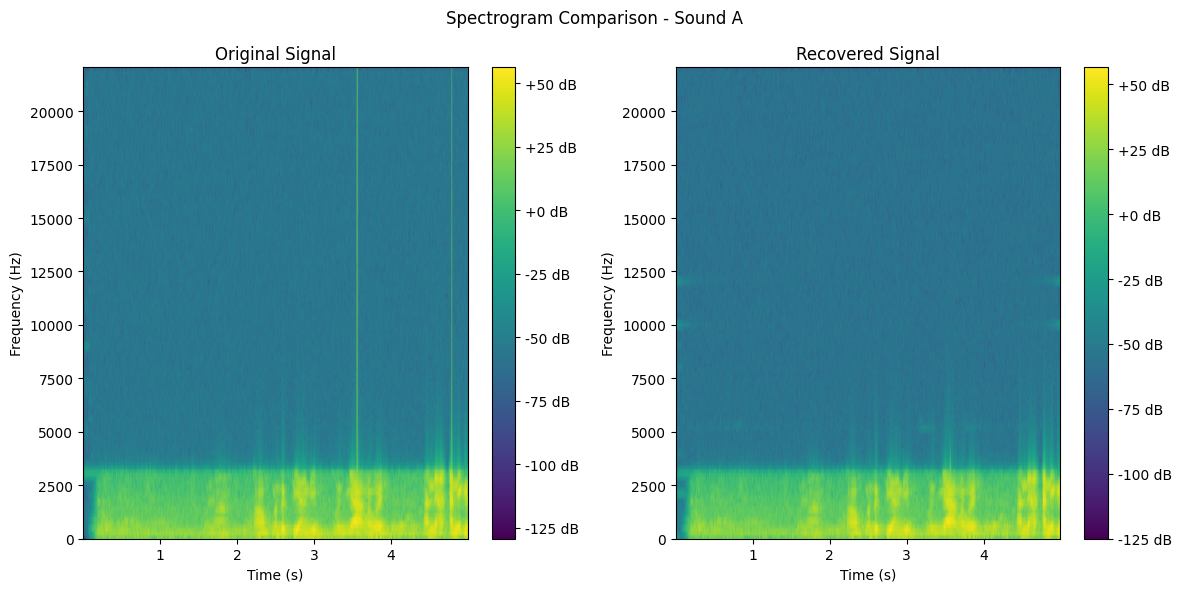

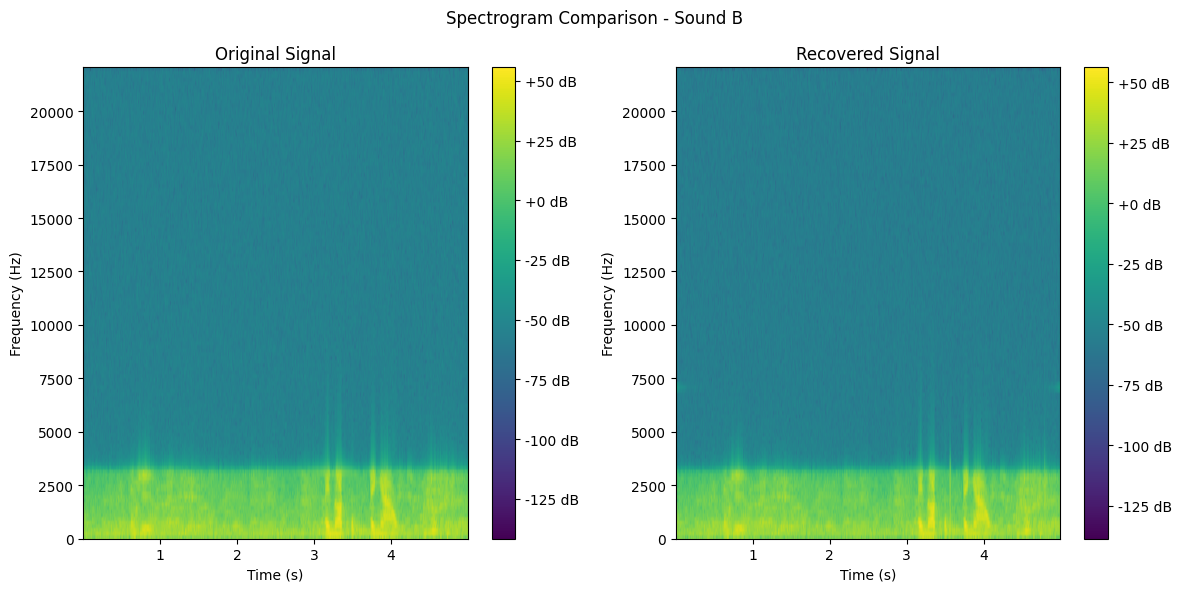

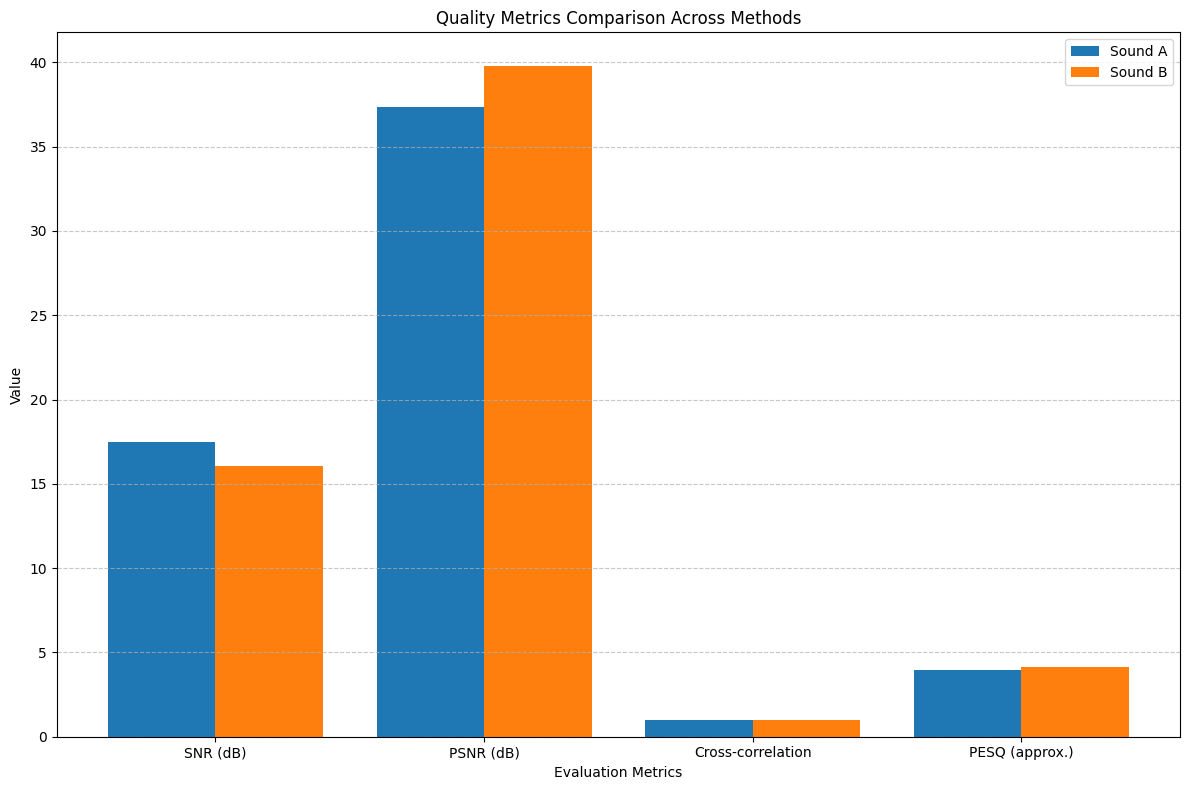

In [7]:
def research_evaluation(original_files, recovered_files, method_names=None):
    """
    Run comprehensive evaluation for research purposes
    
    Parameters:
    -----------
    original_files : list of str
        Paths to original audio files
    recovered_files : list of str
        Paths to recovered audio files
    method_names : list of str
        Names of the methods being compared
    """
    if method_names is None:
        method_names = [f"Method {i+1}" for i in range(len(original_files))]
    
    all_metrics = []
    
    # Calculate metrics for each file pair
    for i, (orig, rec) in enumerate(zip(original_files, recovered_files)):
        print(f"\n=== Evaluating: {method_names[i]} ===")
        metrics, original, recovered, fs = evaluate_audio_quality(orig, rec)
        
        # Print metrics results
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        
        all_metrics.append(metrics)
        
        # Create and save spectrograms
        fig = visualize_spectrograms(original, recovered, fs, 
                                   title=f"Spectrogram Comparison - {method_names[i]}")
        fig.savefig(f'spectrograms_{method_names[i]}.png')
    
    # Create and save metrics comparison
    fig = visualize_metrics(all_metrics, labels=method_names,
                          title="Quality Metrics Comparison Across Methods")
    fig.savefig('metrics_comparison.png')
    
    return all_metrics

# Example research usage
if __name__ == "__main__":
    # Define paths to audio files
    original_files = [
        './soundwav/output_deletenoise1.wav',
        './soundwav/output_deletenoise2.wav'
    ]
    
    recovered_files = [
        './soundwav/extracted_audio1.wav',
        './soundwav/extracted_audio2.wav'
    ]
    
    method_names = ["Sound A", "Sound B"]
    
    # Run comprehensive evaluation
    results = research_evaluation(original_files, recovered_files, method_names)